# Build an Agentic Services with Advanced Reasoning Capabilities

In this workshop we will develop an intelligent agent that integrates cutting-edge ideas from recent research. By leveraging the power of LangGraph and the advanced language models available through Amazon Bedrock, including Claude-3.5 and LLaMA-3.1, we will create a versatile and capable system that can tackle a wide range of challenges.

Key Features:

* Agentic Service: The agent will be designed as a service, allowing for seamless integration and deployment in various applications.
* Dynamic Prompt Rewriting: The agent will dynamically rewrite prompts to optimize the responses from the underlying language models, ensuring more accurate and informative outputs.
* Adaptive Routing: Inspired by the Semantic Router, the routing agent will intelligently route requests to retrieval, web search, or pre-trained LLMs for the most desirable answers, leveraging the strengths of each method for optimal performance. This adaptive routing mechanism will ensure that the agent can effectively handle a diverse set of queries and tasks.
* Hallucination Grader: The agent will include a hallucination grader component to assess the reliability of the generated responses. This will help identify and correct any hallucinations or incomplete answers.
* Human Involvement: If needed, the agent will be able to involve human subject matter experts to provide additional verification and correction of the responses, further improving the trustworthiness and reliability of the system.

By combining these advanced reasoning techniques, the agentic services with orchestration will be able to provide more accurate and informative responses to challenging queries. This will be a significant step forward in the development of intelligent agents that can truly understand and respond to complex questions.

To build this powerful system, we will use LangGraph to create complex, multi-step workflows that involve language models and other components. This will allow us to develop a flexible and scalable system that can handle a wide range of tasks.

To further enhance our capabilities, we will port the original notebook to utilize Amazon Bedrock for LLM inference. This will enable us to leverage the cloud processing power and take advantage of the advanced language models available through Amazon Bedrock, such as Claude-3 and LLaMA-3. By harnessing the power of these cutting-edge language models, we will be able to push the boundaries of what is possible with intelligent agents.

While the choice of vector stores (local chromaDB) will remain unchanged for now, we will explore how to scale this part in future blog posts, ensuring that our system can handle ever-growing amounts of data and information.

Join us in this exciting workshop as we embark on a journey to create an intelligent agent that redefines the boundaries of what is possible with language-based AI systems. Together, we will explore the latest advancements in the field and push the limits of what can be achieved.



In [11]:
!pip install -r requirements.txt  -U 

## 1. Setting Up API keys or tokens 

To access various services, such as Amazon Bedrock for Large Language Models (LLMs) and embedding models, Tavily web search engine, and optional Langchain, you will need to set up and obtain the necessary API keys or tokens. These API keys and tokens serve as authentication credentials that allow your application to securely connect and interact with the respective services.

In [3]:
import os
import boto3

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        #os.environ[var] = getpass.getpass(f"Please provide your {var}")
        os.environ[var] = os.getenv(var.replace("KEY", "token").lower())

_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

# if you work on Google Colab use the following to retrieve your API keys
langchain_api_key = os.getenv('langchain_api_token')
tavily_ai_api_key = os.getenv('tavily_api_token')

session = boto3.Session(profile_name='default')
credentials = session.get_credentials()

# Get the access key ID and secret access key
access_key_id = credentials.access_key
secret_access_key = credentials.secret_key
aws_region = "us-west-2" # choose your region you operate in


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = langchain_api_key

## 2. Creating a Bedrock Runtime Client
We'll create a Bedrock runtime client to connect to the Amazon Bedrock service. Bedrock, a fully managed service by AWS, allows developers to build and deploy generative AI models like large language models (LLMs). This client will enable us to leverage pre-trained LLMs from Amazon, such as the powerful LLaMA3 model from Meta.

Connecting to Bedrock is crucial for building our scalable and secure RAG agent, as it provides the necessary language model for generation capabilities. With the Bedrock runtime client in place, we can integrate LLaMA3 into our workflow and use its advanced natural language processing capabilities to generate accurate responses.

In [4]:
### Select models
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed

options = ["mistral.mistral-large-2402-v1:0", "anthropic.claude-3-haiku-20240307-v1:0", "anthropic.claude-3-5-sonnet-20240620-v1:0", "anthropic.claude-3-Opus-20240229-v1:0"]
# Create the dropdown widget
dropdown = widgets.Dropdown(
    options=options,
    value=options[0],
    description='Choose an option:',
    disabled=False,
)

# Display the dropdown widget
display(dropdown)

Dropdown(description='Choose an option:', options=('mistral.mistral-large-2402-v1:0', 'anthropic.claude-3-haik…

In [6]:
model_id = dropdown.value
model_id 

'anthropic.claude-3-haiku-20240307-v1:0'

In [7]:
from langchain_aws import BedrockLLM, ChatBedrock, ChatBedrockConverse

from botocore.config import Config

config = Config(
    retries = dict(
        max_attempts = 10,
        total_max_attempts = 25,
    )
)

bedrock_client = boto3.client("bedrock-runtime", config=config, 
                              aws_access_key_id=access_key_id,
                              aws_secret_access_key=secret_access_key,)
model_id_c35 = 'anthropic.claude-3-5-sonnet-20240620-v1:0'
#model_id_c3 = 'anthropic.claude-3-sonnet-20240229-v1:0'

model_id_l31= 'meta.llama3-1-70b-instruct-v1:0'
#model_id_c2 = 'anthropic.claude-v2:1'
inference_modifier = {
    "max_tokens": 2048,
    "temperature": 0.01,
    "top_k": 50,
    "top_p": 0.95,
    "stop_sequences": ["\n\n\nHuman"],
}
    
llm_claude35 = ChatBedrock(
    model_id=model_id_c35,
    client=bedrock_client,
    model_kwargs=inference_modifier,
    region_name=aws_region,
)  
llm = ChatBedrockConverse(
    model=model_id,
    client=bedrock_client,
    temperature=0.01,
    max_tokens=2048,
    region_name=aws_region,
)
llm_llama31 = bedrock_llama3_llm = BedrockLLM(
    model_id=model_id_l31,
    client=bedrock_client,
    model_kwargs={"temperature": 0.1, "max_gen_len":1024},
)  

## 3. Create agentic services with multi-agent capability

Creating agentic services with multi-agent capability using Amazon Bedrock, Converse API, and LangChain can be a powerful approach to building intelligent and collaborative systems. Amazon Bedrock provides a foundation for developing large language models (LLMs) and integrating them into applications, while the Converse API enables seamless communication between these models and external services. LangChain, on the other hand, offers a framework for building complex, multi-agent systems that can leverage the capabilities of various LLMs and other AI components. By combining these tools, developers can create agentic services that can engage in dynamic, context-aware interactions, share knowledge, and coordinate their efforts to tackle complex tasks. This approach can be particularly useful in scenarios where a diverse set of specialized agents need to collaborate, such as in enterprise automation, customer service, or research and development.

In [8]:
from IPython.display import Image
from langgraph.prebuilt import create_react_agent
from chromadb import Documents, EmbeddingFunction, Embeddings
from langchain_aws import BedrockEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, AnyMessage
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from botocore.exceptions import ClientError
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_community.tools.tavily_search import TavilySearchResults

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [62]:
class MyEmbeddingFunction(EmbeddingFunction):
    def __init__(self, client, region_name: str, model_id: str):
        self.embedder = BedrockEmbeddings(
            client=client,
            region_name=region_name,
            model_id=model_id
        )
    def embed_query(self, query: str) -> Embeddings:
        return self.embedder.embed_query(query)
    def embed_documents(self, documents: list[str]) -> Embeddings:
        return self.embedder.embed_documents(documents)

class MultiAgentState(TypedDict):
    question: str
    question_type: str
    answer: str
    feedback: str


memory = MemorySaver()
embedding_model_id = "amazon.titan-embed-text-v2:0"

####
# Router
###
def route_question(state: MultiAgentState):
    print('route function execution')
    print(state)
    return state['question_type']


####
# rewrite the question
####
def rewrite_node(state: MultiAgentState):
    """
   REwrite question from query to match domain expert
    Args:
        question (str): The user query
    Returns:
        promt (str): rewrite question to form an expert prompt
    """
    print("---REWRITE QUESTION---")
    c3_template = """Rewrite the question by following the {{instruction}} to capture more precise and comprehensive intent from {question}.
    <instructions> 
        <step>Identify the key purposes, concepts and entities in the original {{question}}.</step> 
        <step>Rephrase the question to be more specific and focused, ensuring that the language is clear and unambiguous.</step> 
        <step>Provide additional context or background information that may be helpful for web search or RAG system to better understand and respond to the question.</step> 
        <step>Output your reqritten question only without answering it or repeating the riginal one.</step>
    </instructions> 
    """
    
    c3_prompt = ChatPromptTemplate.from_template(c3_template)
    #chain = ( c3_prompt | llm_c3 | StrOutputParser() | (lambda x: x.split("\n")))
    rewritten_chain = ( c3_prompt | llm | StrOutputParser() )
    rewritten_question = rewritten_chain.invoke({"question": state['question']})
    print(rewritten_question)
    return {"answer": rewritten_question}

    
#####
# Router agent
#####
question_category_prompt = '''You are a senior specialist of analytical support. Your task is to classify the incoming questions. 
Depending on your answer, question will be routed to the right team, so your task is crucial for our team. 
There are 3 possible question types: 
- Vectorstore - Answer questions related to pre-indexed healthcare and medical research related topics stored in the vactorestore.
- Websearch- Answer questions based on events happened recently, after most LLM's cut-off dates. 
- General - Answer questions for LLM or a few LLMs.
Return in the output only one word (VECTORSTORE, WEBSEARCH or GENERAL).
'''

def router_node(state: MultiAgentState):
    print('Router node started execution')
    messages = [
        SystemMessage(content=question_category_prompt), 
        HumanMessage(content=state['question'])
    ]
    model = llm #ChatOpenAI(model="gpt-4o-mini")
    response = model.invoke(messages)
    print('Question type: %s' % response.content)
    return {"question_type": response.content}


#####
# Search agent
#####
def search_expert_node(state: MultiAgentState):
    tavily_tool = TavilySearchResults(max_results=5)

    search_expert_system_prompt = '''
    You are an expert in LangChain and other technologies. 
    Your goal is to answer questions based on results provided by search.
    You don't add anything yourself and provide only information baked by other sources. 
    '''
    #model = ChatOpenAI(model="gpt-4o-mini")
    model = llm
    search_agent = create_react_agent(model, [tavily_tool],
        state_modifier = search_expert_system_prompt)
    messages = [HumanMessage(content=state['question'])]
    result = search_agent.invoke({"messages": messages})
    return {'answer': result['messages'][-1].content}


#######
# RAG
#######
def rag_node(state: MultiAgentState):
    urls = [
        "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC11127599/",
        "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC11127585/",
        "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC11127581/"
    ]
    c3_template = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. Use  less than 10 sentences maximum and keep the answer concise. 
    
    {context} 
    
    Use these to craft an answer to the question: {question}"""
    c3_prompt = ChatPromptTemplate.from_template(c3_template)
    
    docs = [WebBaseLoader(url).load() for url in urls]    
    docs_list = [item for sublist in docs for item in sublist]
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=4000, chunk_overlap=400
    )
    doc_splits = text_splitter.split_documents(docs_list)
    
    embedding_function = MyEmbeddingFunction(client = bedrock_client,
                                             region_name=aws_region,
                                             model_id=embedding_model_id)
    # Add to vectorDB
    vectorstore = Chroma.from_documents(
        documents=doc_splits,
        embedding=embedding_function,
        collection_name="rag-chroma-titan-embed-text-v2-1",
    )
    retriever = vectorstore.as_retriever(
        search_type="mmr",
        search_kwargs={'k': 3, 'lambda_mult': 0.25})
    rag_chain = c3_prompt | llm | StrOutputParser()
    documents = retriever.invoke(state['question'])
    generation = rag_chain.invoke({"context": documents, "question": state['question']})
    return {'answer': generation}


#####
# LLM node
####
def llm_node(state: MultiAgentState):
    model_ids = ["mistral.mistral-large-2402-v1:0", "meta.llama3-1-70b-instruct-v1:0"]
    max_tokens = 2048
    temperature = 0.01
    top_p = 0.95
    conversation = [
        {
            "role": "user",
            #"system": "You are a domain expert who can understand the intent of user query and answer question truthful and professionally. Please, don't provide any unchecked information and just tell that you don't know if you don't have enough info.",
            "content": [{"text": state['question']}],
        }
    ]
    try:
        # Send the message to the model, using a basic inference configuration.
        responses = []
        for model_id in model_ids:
            response = bedrock_client.converse(
                modelId=model_id,
                messages=conversation,
                inferenceConfig={"maxTokens": max_tokens, "temperature": temperature, "topP": top_p},
            )
        
            # Extract and print the response text.
            responses.append( response["output"]["message"]["content"][0]["text"])

        ###
        # Combine the answers to form a unified one
        ###
        c3_template = """Your are a domain expert and your goal is to Merge and eliminate redundant elements from {{responses}} that captures the essence of all input while adhering to the following the {{instruction}}.
        <instructions> 
            <step>Aggregate relevant information from the provided context.</step> 
            <step>Eliminate redundancies to ensure a concise response.</step> 
            <step>Maintain fidelity to the original content.</step> 
            <step>Add additional relevent info to the question or removing iirelevant information.</step>
        </instructions> 
        <responses>
            {responses}
        </responses>
        """
        
        messages = [
            SystemMessage(content=c3_template), 
            HumanMessage(content=state['question'])
        ]

        return {'answer': llm_claude35.invoke(messages)}
    except (ClientError, Exception) as e:
        print(f"ERROR: Can't invoke '{model_id}'. Reason: {e}")


####
# Human in the loop
###

def human_feedback_node(state: MultiAgentState):
    pass
editor_prompt = '''You're an editor and your goal is to provide the final answer to the customer, taking into account the feedback. 
You don't add any information on your own. You use friendly and professional tone. 
In the output please provide the final answer to the customer without additional comments.
Here's all the information you need.


Question from customer: 
----
{question}
----
Draft answer:
----
{answer}
----
Feedback: 
----
{feedback}
----
'''

def editor_node(state: MultiAgentState):
    print(state)
    messages = [
        SystemMessage(content=editor_prompt.format(question = state['question'], answer = state['answer'], feedback = state['feedback']))
    ]
    model = llm
    response = model.invoke(messages)
    return {"answer": response.content}

#### Additional functions

In [67]:
#####
# Hallucination grader
#####
from langchain.callbacks.base import BaseCallbackHandler

class MyCustomHandler(BaseCallbackHandler):
    def on_llm_end(self, response, **kwargs):
        print(f"Response: {response}")
        
def hallucination_grader_node(state:MultiAgentState):
    c3_template = """You are a grader assessing whether an answer is grounded in supported by facts. 
        Give a binary score 'pass' or 'fail' score to indicate whether the answer is grounded in supported by a 
        set of facts in your best knowledge. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
        
        Here is the answer: {answer}"""
    c3_prompt = ChatPromptTemplate.from_template(c3_template)
    
    # Grade by a diff model in this case Claude 3
    #hallucination_grader = prompt | llm_llama31  | JsonOutputParser() 
    hallucination_grader = c3_prompt | llm_claude35 | JsonOutputParser()
    score = hallucination_grader.invoke({"answer": state['answer'], "callbacks": [MyCustomHandler()]})
    return {'answer': score}


####
# Extra function but not as a node
####
def decide_to_search(state:MultiAgentState):
    """
    Determines whether to generate an answer, or add web search
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """
    l31_prompt = PromptTemplate(
        template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether
        an {answer} is grounded in / relevant to the {question}. Give a binary score 'yes' or 'no' score to indicate
        whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a
        single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
        Here is the answer:
        {answer}
        Here is the question: {question}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["question", "answer"],
    )
    
    answer_grader = l31_prompt | llm_llama31 | JsonOutputParser()
    print("---ASSESS GRADED ANSWER AGAINST QUESTION---")
    relevance = answer_grader.invoke({"answer": state["answer"], "question": state["question"]})
    print(relevance)
    if "yes" in relevance['score'].lower():
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: the answer is relevant to the question so off to human review ---"
        )
        return "to_human"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: the answer is NOT relevant to the question then try web search ---")
        return "do_search"

## 4. Defining the Reasoning Flow with LangGraph Nodes and Edges

Implement nodes representing key actions: document retrieval, document grading, web search, and answer generation. Define conditional edges for decision-making: route the question, decide on document relevance, and grade the generated answer. Set up the workflow graph with entry points, nodes, and edges to ensure a logical progression through the RAG agent's steps. LangGraph allows us to define a graph-based workflow for our RAG agent, integrating document retrieval, question routing, answer generation, and self-correction into an efficient pipeline.

Key steps include:

* Question rewrite: Rewrite the query for better intend classification
* Routing: Deciding whether the question should go to the RAG, LLMs or a web search.
* Hallucination Grading: Ensuring the generated answer is grounded in the retrieved documents.
* Human in the loop: In case the answer fall bwloew desired quality, insert human feedback

LangGraph lets us seamlessly integrate these steps into a modular, adaptable workflow, enhancing the agent's ability to handle diverse queries.

In [64]:
orch = StateGraph(MultiAgentState)
orch.add_node("rewrite", rewrite_node)
orch.add_node("router", router_node)
orch.add_node('search_expert', search_expert_node)
orch.add_node('rag_expert', rag_node)
orch.add_node('general_assistant', llm_node)
orch.add_node('hallucination_grader', hallucination_grader_node)
orch.add_node('human', human_feedback_node)
orch.add_node('editor', editor_node)

orch.add_conditional_edges(
    "router", 
    route_question,
    {'VECTORSTORE': 'rag_expert', 'WEBSEARCH': 'search_expert', 'GENERAL': 'general_assistant'}
)

orch.set_entry_point("rewrite")
orch.add_edge('rewrite', 'router')
#orch.add_edge('rag_expert', 'human')
orch.add_conditional_edges(
    "rag_expert",
    decide_to_search,
    {
        "to_human": "human",
        "do_search": "search_expert",
    },
)
#orch.add_edge('search_expert', 'human')
orch.add_conditional_edges(
    "search_expert",
    decide_to_search,
    {
        "to_human": "human",
        "do_search": "search_expert",
    },
)
orch.add_edge('general_assistant', 'hallucination_grader')
orch.add_edge('hallucination_grader', 'human')
orch.add_edge('human', 'editor')
orch.add_edge('editor', END)

## 5. Display the orchestration flows

The orchestration flows can be depicted using the following  visual representation that illustrate the sequence of operations, the data transformations, and the control flow between the different modules or algorithms involved in the vision comprehension process. By providing a clear and concise visual representation of the orchestration, it becomes easier for developers, researchers, and stakeholders to understand the overall architecture, identify potential bottlenecks or optimization opportunities, and communicate the system's functionality and performance.

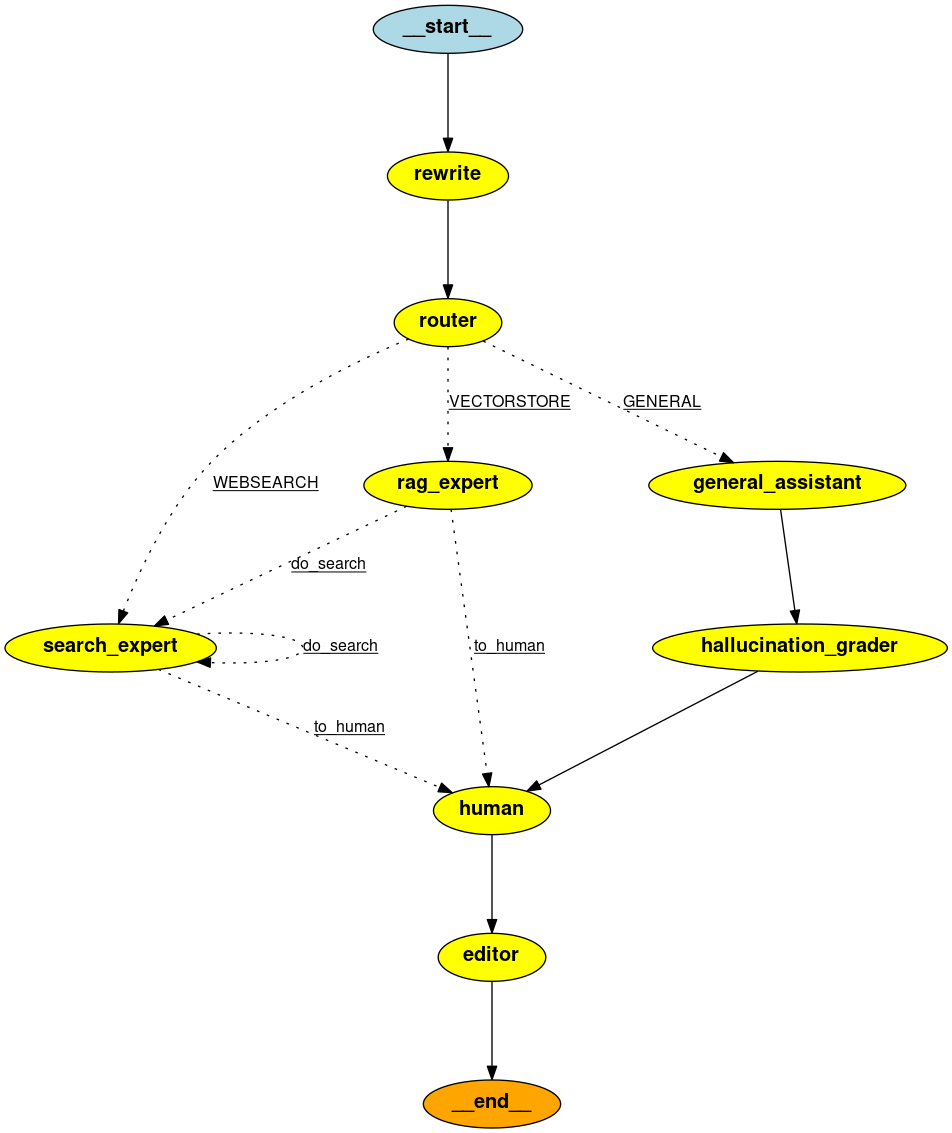

In [65]:
graph = orch.compile(checkpointer=memory, interrupt_before = ['human'])
Image(graph.get_graph().draw_png())

## 6. Execute this pipeline with query driven reasoning and 

Executing agentic services with multi-agent capability on executing a pipeline with query-driven reasoning and reactions involves the development of a system that can autonomously perform tasks and make decisions based on the information it gathers and the queries it receives. This system would consist of multiple intelligent agents, each with its own set of capabilities and knowledge, working together to achieve a common goal. The agents would use query-driven reasoning to understand the user's intent and then react accordingly, executing the necessary steps in the pipeline to provide the desired outcome. This approach allows for a more dynamic and adaptive system that can handle a wide range of tasks and respond to changing conditions in real-time. The result is a powerful and flexible service that can assist users with a variety of needs, from information retrieval to complex problem-solving.

In [68]:
thread = {"configurable": {"thread_id": "42",  "recursion_limit": 5}}
results = []
prompts =["Under what circumstances a patient should be screened for ectopic ACTH syndrome(EAS)?",
          "What could be the typical clinical symptoms of Blepharitis?",
        "How many total medals did the US Olympic Team won in Paris 2024?",
        "Why Steve Jobs was considered a legent in the tech world?"]

for prompt in prompts:
    for event in graph.stream({
        'question':prompt,
    }, thread):
        print(event)
        results.append(event)
    print("\n\n---------------------------------------\n\n")

---REWRITE QUESTION---
Key purposes, concepts and entities in the original question:
- Screening for ectopic ACTH syndrome (EAS)
- Circumstances or situations when a patient should be screened for EAS

Rewritten question:
Under what clinical conditions or patient presentations should healthcare providers consider screening for ectopic adrenocorticotropic hormone (ACTH) syndrome (EAS)? EAS is a rare condition caused by ectopic (abnormal) production of ACTH, leading to excess cortisol secretion. Early detection of EAS is important to guide appropriate diagnostic workup and treatment.

Additional context:
EAS is a challenging diagnosis to make, as it can present with non-specific symptoms of Cushing's syndrome, such as weight gain, hypertension, diabetes, and muscle weakness. EAS should be suspected in patients with Cushing's syndrome who do not have a pituitary adenoma or other clear underlying cause. Identifying the appropriate clinical scenarios for EAS screening can help healthcare pr

Error in LangChainTracer.on_llm_end callback: TracerException('No indexed run ID 7984e5de-17f2-4e8d-bd81-e13255b92398.')


{'score': 'yes'}
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
{'rag_expert': {'answer': 'Based on the information provided in the retrieved context, patients should be screened for ectopic ACTH syndrome (EAS) under the following circumstances:\n\n1. Patients who exhibit a rapid progression of ACTH-dependent hypercortisolism should be screened for EAS. The rapid onset of severe hypercortisolism accompanied by catabolic symptoms is often characteristic of EAS.\n\n2. Patients with an adrenal mass and increased plasma ACTH levels should be evaluated for the possibility of an ACTH-secreting pheochromocytoma, even in the absence of excessive catecholamine secretion (a "silent" pheochromocytoma).\n\n3. When the source of ACTH production is unclear, and the patient has clinical and biochemical features of Cushing\'s syndrome, the possibility of EAS should be considered, and further diagnostic workup should be pursued.\n\n4. In cases where the pituitary is not 

Error in LangChainTracer.on_llm_end callback: TracerException('No indexed run ID e9d7575d-923a-4b8e-b8ae-ab92fb27c18d.')


{'score': 'no'}
---DECISION: Human review---
{'rag_expert': {'answer': "The given context does not contain any information about the clinical symptoms of blepharitis. The documents discuss a case of Cushing's syndrome due to a corticotropin-releasing hormone and adrenocorticotropic hormone-secreting pheochromocytoma. There is no mention of blepharitis or its symptoms."}}
---ASSESS GRADED ANSWER AGAINST QUESTION---


Error in LangChainTracer.on_llm_end callback: TracerException('No indexed run ID 362ffedd-dc15-4260-9ce9-c368b812c1e5.')


{'score': 'yes'}
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
{'search_expert': {'answer': 'Based on the search results, the typical clinical symptoms of blepharitis include:\n\n- Redness and swelling of the eyelids\n- Itching, burning, or irritation of the eyes\n- Crusty or flaky buildup on the eyelids, especially at the base of the eyelashes\n- Dry eyes\n- Blurred vision\n- Sensitivity to light\n\nThe inflammation and irritation can affect one or both eyes. Blepharitis is a chronic condition that can come and go, with periods of flare-ups followed by periods of remission.'}}


---------------------------------------


---REWRITE QUESTION---
Key purposes, concepts and entities in the original question:
- The US Olympic Team's performance in the 2024 Paris Olympics
- The total number of medals won by the US Olympic Team

Rewritten question:
How many total medals (gold, silver, and bronze) did the United States Olympic Team win at the 2024 Summer Olympi

Error in LangChainTracer.on_llm_end callback: TracerException('No indexed run ID 15d3a945-4e0b-4ae9-bd26-1300cc534a63.')


{'score': 'yes'}
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
{'search_expert': {'answer': 'Based on the search results, it appears that the US Olympic Team won a total of 126 medals at the Paris 2024 Olympics, including 40 gold, 44 silver, and 42 bronze medals. This was a record-setting performance for Team USA, exceeding their medal haul from the previous Tokyo 2020 Olympics.'}}


---------------------------------------


---REWRITE QUESTION---
Key purposes, concepts and entities in the original question:
- Understand why Steve Jobs was considered a legend in the tech world

Rewritten question:

What were the key factors and achievements that made Steve Jobs widely regarded as a legendary figure in the technology industry?

Additional context:
Steve Jobs was the co-founder and former CEO of Apple Inc., a company that revolutionized personal computing, smartphones, and other consumer electronics. He is known for his visionary leadership, innovative pr

### 3.3 Testing the WebSearch
For a test on the web search, we utilize the question, "Who are the Bears expected to draft first in the NFL draft?". As this request needs up-to-date information and should not be based on the knowledge base, we expect it to go directly to a web search.

question = "How many total medals did the US Olympic Team won in Paris 2024?"

inputs = {"question": question}
my_config = {"configurable": {"thread_id": "3", "recursion_limit": 5}}
for output in app.stream(inputs, my_config):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

### 3.4 Further Improvements
If you look to improve the above code further, here are a few suggestions:

* Expand the Web Search Capabilities
Currently, the web search capabilities only use the Tavily-AI Langchain tool, although Tavily AI has much more functionality to offer. You can, for example, include and exclude certain domains and websites, add the current date to target a specific timeframe of the results, and include a generic search on Google or DuckDuckGo to complement the Tavily-AI search.

* Retrieve the topics dynamically
We hard-code the topics represented in our knowledge base. If we know the topics ahead of time, this is a perfectly valid approach. However, for more fine-grained retrieval, we should consider including vector metadata in our vector store.

* Change the knowledge base to a more scaleable option
As the chromaDB vector store is running on our local instance, we have a scalability limit that is imposed upon us. We can use products like Pinecone or Amazon OpenSearch, just to name a few.
Langgraph
Langchain
Agents
Bedrock


### 4. Display the graph